<font color='#E27271'>

# *Unveiling Complex Interconnections Among Companies through Learned Embeddings*</font>

-----------------------
<font color='#E27271'>

Ethan Moody, Eugene Oon, and Sam Shinde</font>

<font color='#E27271'>

August 2023</font>

-----------------------
<font color='#00AED3'>

# **Model: SetFit - Efficient Few-short Learning with Sentence Transformers** </font>
-----------------------

In continuation of our work with Sentence Transformers, where we solely trained the classification head using fixed embeddings as inputs, we are now expanding our approach by exploring the fine-tuning of both the Sentence Transformers and the classification head. To achieve this, we will utilize the SetFit framework, an efficient and prompt-free solution for few-shot fine-tuning of Sentence Transformers.

The SetFit framework has been specifically designed to excel in scenarios with limited labeled data, requiring no prompts or verbalisers and offering fast training times. (https://github.com/huggingface/setfit/blob/main/README.md)

As with our previous implementation, the primary objective remains unchanged: predicting the GICS sector classification for companies listed on the NYSE and NASDAQ. The input data for our model will continue to be based on Item 1 ("Business") of SEC 10-K reports.


## [1] Installs, Imports and Setup Steps

### [1.1] Complete Initial Installs

In [ ]:
!pip install torch --quiet
!pip install transformers datasets --quiet
!pip install setfit --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 492.4/492.4 kB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 32.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 42.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.9/45.9 kB 932.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.4 MB/s eta 0:00:

### [1.2] Import Packages

In [ ]:
import numpy as np
import pandas as pd
import re

import tensorflow as tf

import datasets
from datasets import Dataset

from tqdm import tqdm

from sentence_transformers.losses import CosineSimilarityLoss
from setfit import SetFitTrainer, SetFitModel, sample_dataset

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

### [1.3] Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## [2] Modeling Data Preparation

### [2.1] Load filtered training and testing data from csv

In [ ]:
# Define the path of filtered training data
output_train_csv_path = '/content/drive/My Drive/Colab Notebooks/project/eugene/nsp500_2022bus_final.csv'
# Define the path of filtered testing data
output_test_csv_path = '/content/drive/My Drive/Colab Notebooks/project/eugene/sp500_2022bus_final.csv'

# Read the CSV file into a new DataFrame "df_train"
df_train = pd.read_csv(output_train_csv_path)
# Read the CSV file into a new DataFrame "df_test"
df_test = pd.read_csv(output_test_csv_path)

### [2.2] Convert GICS sector classification to numerical labels (combining Consumer Disretionary and Consumer Staples into a single label)

In [ ]:
# Get the unique values from the 'sector' column of the DataFrame 'df_train'
labels = sorted(df_train.sector.unique())
# Create a dictionary to store the mapping of each unique 'sector' value to its corresponding numerical label
label_dict = {'Communication Services': 0, 'Consumer Discretionary': 1,'Consumer Staples': 1,
              'Energy': 2, 'Financials': 3, 'Health Care': 4, 'Industrials': 5,
              'Information Technology': 6, 'Materials': 7, 'Real Estate': 8, 'Utilities': 9}

In [ ]:
# Map the 'sector' values in 'df_train' and 'df_test' to their corresponding numerical labels
df_train["label"] = df_train.sector.replace(label_dict)
df_test["label"] = df_test.sector.replace(label_dict)

### [2.3] Create function to clean Item 1 ("Business") of 10K report

In [ ]:
def clean(rawtext):
  """
  Function to clean the raw text by removing unwanted elements, which might impact model performance.
  The following cleaning steps are performed:
  1. Remove specific (non-breaking space) character sequence '\xa0'.
  2. Remove New Line characters '\n'.
  3. Remove consecutive whitespace characters and replace them with a single space.
  4. Replace any table content identified by HTML <table> tags with an empty string.
  5. Keep only lowercase or uppercase alphabetic characters (a-z, A-Z), whitespace characters (\s), and dots (.) and remove all other characters.
  6. Replace one or more consecutive spaces with a single space.

  Parameters:
  rawtext (str): The raw text that needs to be cleaned.

  Returns:
  str: The cleaned text after performing all the specified cleaning steps.
  """
  # Remove specific (non-breaking space) character sequence '\xa0'
  rawtext = rawtext.replace('\\xa0','')

  # Remove New Line characters '\\n'
  rawtext = rawtext.replace('\\n','')

  # Replace consecutive whitespace characters with a single space
  rawtext = re.sub('\s\s+',' ',rawtext)

  # Replace new line characters with a space
  rawtext = re.sub('\n',' ',rawtext)

  # Replace table content identified by HTML <table> tags with an empty string
  rawtext = re.sub("(?is)<table[^>]*>(.*?)<\/table>", "", rawtext)

  # Keep only lowercase or uppercase alphabetic characters (a-z, A-Z), whitespace characters (\s), and dots (.)
  rawtext = re.sub(r'[^A-Za-z .]+', '', rawtext)

  # Replace one or more consecutive spaces with a single space
  rawtext = re.sub(' +', ' ', rawtext)

  return rawtext

### [2.4] Clean and finalize training and testing data

In [ ]:
# Apply 'clean' function to clean the 'business' column of both 'df_train' and 'df_test'
df_train["business"] = df_train["business"].apply(lambda x: clean(x))
df_test["business"] = df_test["business"].apply(lambda x: clean(x))

In [ ]:
# Display dimensions of 'df_train' and 'df_test'
print(f"Shape of Training Data: {df_train.shape}")
print("="*50)
print(f"Shape of Testing Data: {df_test.shape}")
print("="*50)

# Display information of 'df_train' and 'df_test'
print(df_train.info())
print("="*50)
print(df_test.info())

Shape of Training Data: (3682, 6)
Shape of Testing Data: (500, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3682 entries, 0 to 3681
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   name      3682 non-null   object
 1   ticker    3682 non-null   object
 2   cik       3682 non-null   int64 
 3   business  3682 non-null   object
 4   sector    3682 non-null   object
 5   label     3682 non-null   int64 
dtypes: int64(2), object(4)
memory usage: 172.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   name      500 non-null    object
 1   ticker    500 non-null    object
 2   cik       500 non-null    object
 3   business  500 non-null    object
 4   sector    500 non-null    object
 5   label     500 non-null    int64 
dtypes: int64(1), object(5)
memory usage: 23.6+ KB
None


### [2.5] Partition Data for Modeling

In [ ]:
# Keep only the 'business' and 'label' columns required
df_train = df_train[["business","label"]]
df_train.reset_index(drop=True, inplace=True)

df_test = df_test[["business","label"]]
df_test.reset_index(drop=True, inplace=True)

# Display information of 'df_train' and 'df_test'
print(df_train.info())
print("="*50)
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3682 entries, 0 to 3681
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   business  3682 non-null   object
 1   label     3682 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 57.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   business  500 non-null    object
 1   label     500 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 7.9+ KB
None


In [ ]:
# Create Datasets from DataFrames
ds_train = Dataset.from_pandas(df_train)
ds_test = Dataset.from_pandas(df_test)

# Display contents of created Datasets
print(ds_train)
print(ds_test)

Dataset({
    features: ['business', 'label'],
    num_rows: 3682
})
Dataset({
    features: ['business', 'label'],
    num_rows: 500
})


In [ ]:
# Extract the labels from the 'ds_train' Dataset
strat_labels = ds_train["label"]

# Split the 'ds_train' Dataset into training and validation datasets
# 'Xy_ds_train' will be the training dataset, and 'Xy_ds_val' will be the validation dataset
Xy_ds_train, Xy_ds_val = train_test_split(ds_train, test_size = 0.15, random_state=42, stratify=strat_labels)

# Convert 'Xy_ds_train' and 'Xy_ds_val' back to Datasets
Xy_ds_train = Dataset.from_dict(Xy_ds_train)
Xy_ds_val = Dataset.from_dict(Xy_ds_val)

# Display contents of created Datasets
print(Xy_ds_train)
print(Xy_ds_val)

Dataset({
    features: ['business', 'label'],
    num_rows: 3129
})
Dataset({
    features: ['business', 'label'],
    num_rows: 553
})


In [ ]:
# Call the 'sample_dataset()' function with the 'Xy_ds_train' Dataset as input
# 'num_samples' indicates number of samples will be randomly selected from 'Xy_ds_train'
# SetFit authors recommended minimum of 8
# This approach of sampling as deals with the imbalance labels
Xy_ds_sample = sample_dataset(Xy_ds_train, label_column="label", num_samples=24)

# Shuffle the output (samples) of Xy_ds_sample
Xy_ds_sample = Xy_ds_sample.shuffle(seed=42)

# Display contents of created Dataset
print(Xy_ds_sample)

Dataset({
    features: ['business', 'label'],
    num_rows: 240
})


## [3] Fine-Tuning SetFit Model

### [3.1] Fine-tuning with a pure PyTorch model

Adapted from the notebooks of the authors of SetFit (https://github.com/huggingface/setfit/blob/main/notebooks/text-classification.ipynb).

In [ ]:
# Calculate the number of classes in the 'Xy_ds_sample' Dataset
num_classes = len(Xy_ds_sample.unique("label"))

# Create a SetFitModel for fine-tuning the Sentence Transformer model
model = SetFitModel.from_pretrained("sentence-transformers/paraphrase-mpnet-base-v2",
                                    use_differentiable_head=True,
                                    head_params={"out_features": num_classes})

# Create a SetFitTrainer for training the model
trainer = SetFitTrainer(
    model=model,
    train_dataset=Xy_ds_sample,
    eval_dataset=Xy_ds_val,
    loss_class=CosineSimilarityLoss,
    batch_size = 8,
    num_iterations=20,
    column_mapping={"business":"text", "label":"label"})

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


In [ ]:
# Freeze the weights of the final layer and apply contrastive learning
trainer.freeze()
# Use learning rate of 1e-5 and epoch as suggested by authors
trainer.train(body_learning_rate=1e-5, num_epochs=1)

Applying column mapping to training dataset


Generating Training Pairs:   0%|          | 0/20 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 9600
  Num epochs = 1
  Total optimization steps = 1200
  Total train batch size = 8


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1200 [00:00<?, ?it/s]

In [ ]:
# Now that model body is tuned, we unfreeze the head and train it
trainer.unfreeze(keep_body_frozen=True)
# Use learning rate and epochs as suggested by authors
trainer.train(learning_rate=1e-2, num_epochs=50)

Applying column mapping to training dataset
The `max_length` is `None`. Using the maximum acceptable length according to the current model body: 512.


Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

### [3.2] Evaluate model on validation dataset

In [ ]:
# Evaluate model on validation dataset
trainer.evaluate()

Applying column mapping to evaluation dataset
***** Running evaluation *****


{'accuracy': 0.8444846292947559}

### [3.3] Save pre-trained model locally

In [ ]:
# Define the path to save the model locally
save_directory = '/content/drive/My Drive/Colab Notebooks/project/eugene/Model'
# Save the model
trainer.model._save_pretrained(save_directory=save_directory)

### [3.4] Load the pre-trained model

In [ ]:
# Load pre-trained model
saved_model = SetFitModel._from_pretrained(save_directory)

## [4] Model Evaluation against Testing Data

In [ ]:
# Get predictions on the testing dataset (labels and probabilities)
y_pred_labels = saved_model.predict(ds_test["business"])
y_pred_probs = saved_model.predict_proba(ds_test["business"])

In [ ]:
# Create the labels for the classification report
labels_cr = ['Communication Services', 'Consumer Combined', 'Energy', 'Financials', 'Health Care',
             'Industrials', 'Information Technology', 'Materials', 'Real Estate', 'Utilities']
# Generate multiclass classification report based on testing dataset predictions
cr = classification_report(ds_test["label"], y_pred_labels.cpu().numpy(), target_names=labels_cr)

# Display classification report
print(cr)

                        precision    recall  f1-score   support

Communication Services       0.63      0.95      0.76        20
     Consumer Combined       0.88      0.76      0.81        90
                Energy       1.00      0.87      0.93        23
            Financials       0.88      0.83      0.86        72
           Health Care       1.00      0.72      0.84        65
           Industrials       0.70      0.76      0.73        75
Information Technology       0.71      0.82      0.76        65
             Materials       0.75      0.93      0.83        29
           Real Estate       0.76      0.81      0.78        31
             Utilities       0.91      1.00      0.95        30

              accuracy                           0.81       500
             macro avg       0.82      0.84      0.83       500
          weighted avg       0.83      0.81      0.81       500



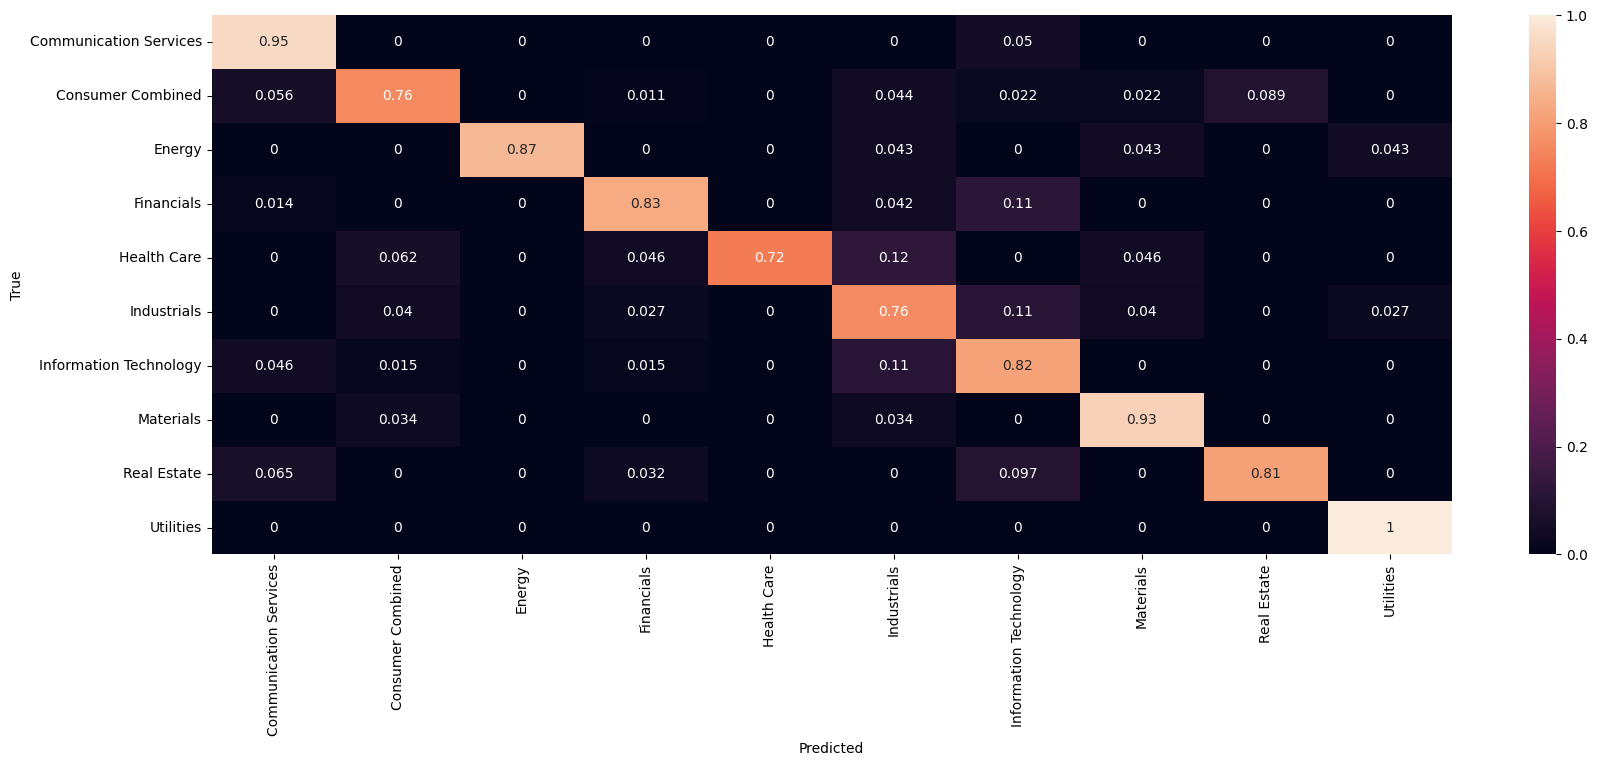

In [ ]:
# Generate a confusion matrix to show testing results by class
cm = tf.math.confusion_matrix(ds_test["label"], y_pred_labels.cpu().numpy())
cm = cm.numpy()
cm_normalized = cm / cm.sum(axis=1, keepdims=True)

# Display confusion matrix
plt.figure(figsize=(20,7))
sns.heatmap(
    cm_normalized,
    annot=True,
    xticklabels=labels_cr,
    yticklabels=labels_cr)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()